https://stepik.org/lesson/501479/step/1?unit=493164  
https://drive.google.com/drive/folders/15UoRIwvCOZ-6c624m5NTDfbFizOs-C0N  
https://www.kaggle.com/c/advanced-dls-spring-2021/  
https://github.com/yurkai/churn/blob/master/week07.ipynb  
https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix  
https://github.com/yurkai/churn/blob/master/week07.ipynb  
https://stackoverflow.com/questions/52356473/how-to-print-categories-in-pandas-cut  
https://stackoverflow.com/questions/44511636/matplotlib-plot-feature-importance-with-feature-names  !!

Kaggle Team: **Valentin_Aliferov** (0.85303)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

target_col = 'Churn'

In [3]:
# loading data
test_data = pd.read_csv('./test.csv')
train_data = pd.read_csv('./train.csv')

In [4]:
# imbalanced classes (but not too much)
print(f'{train_data[target_col].mean() * 100:.1f}% class 1 (target)')

26.2% class 1 (target)


In [5]:
# no missing values in categorical features
test_cat_na = test_data[cat_cols].isna().sum().sum()
train_cat_na = train_data[cat_cols].isna().sum().sum()
print(f'cat_cols_na: {train_cat_na}, {test_cat_na} (train, test)')

cat_cols_na: 0, 0 (train, test)


In [6]:
# Numerical Features (train)
# TotalSpent: wrong dtype
# TotalSpent: 9 missing values
# ClientPeriod: 9 zeros (missing values)
data = train_data[num_cols].copy()
data['TotalSpent_float'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
pd.DataFrame({'dtype': data.dtypes, 'na': data.isna().sum(), 'zero': (data == 0).sum()})

,dtype,na,zero
ClientPeriod,int64,0,9
MonthlySpending,float64,0,0
TotalSpent,object,0,0
TotalSpent_float,float64,9,0


In [7]:
# Numerical Features (test)
# TotalSpent: wrong dtype
# TotalSpent: 2 missing values
# ClientPeriod: 2 zeros (missing values)
data = test_data[num_cols].copy()
data['TotalSpent_float'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
pd.DataFrame({'dtype': data.dtypes, 'na': data.isna().sum(), 'zero': (data == 0).sum()})

,dtype,na,zero
ClientPeriod,int64,0,2
MonthlySpending,float64,0,0
TotalSpent,object,0,0
TotalSpent_float,float64,2,0


,size,mean,median,mode,std,na,zero
HasContractPhone,,,,,,,
Month-to-month,2920,18.147603,12,1,17.684934,0,0
One year,1082,41.929760,44,53,18.891057,0,1
Two year,1280,56.845312,65,72,18.291818,0,8


,size,mean,median,mode,std,na,zero
HasContractPhone,,,,,,,
Month-to-month,955,17.697382,12,1,17.706599,0,0
One year,391,42.363171,44,69,19.452007,0,0
Two year,415,56.395181,63,72,17.970265,0,2


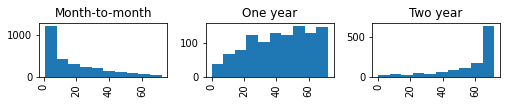

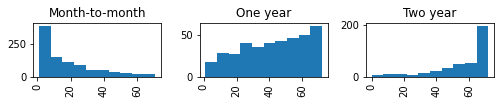

In [8]:
# ClientPeriod: choosing strategy for filling zeros
# 'HasContractPhone': min std within groups
# We can fill missing values with median of each group

def filling_zeros_strategy_report(data):
    def na(x): return x.isnull().sum()
    def zero(x): return (x == 0).sum()
    def mode(x): return x.value_counts().index[0]
    agg_funcs = ('size','mean','median',mode,'std',na,zero)
    display(data.groupby('HasContractPhone')['ClientPeriod'].agg(agg_funcs))
    data.hist(column='ClientPeriod', by='HasContractPhone', layout=(1,3), figsize=(8,1))

filling_zeros_strategy_report(train_data.copy())
filling_zeros_strategy_report(test_data.copy())

In [9]:
# ClientPeriod: checking strategy

def check_filling_zeros(data):
    # x.mean(), x.median(), stats.mode(x)[0][0]
    replace = lambda x: x.replace(0, x.median())
    idx = data[data['ClientPeriod'] == 0].index
    data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace)
    display(data.loc[idx,['ClientPeriod','HasContractPhone']])

check_filling_zeros(train_data.copy())
check_filling_zeros(test_data.copy())

,ClientPeriod,HasContractPhone
1048,65.0,Two year
1707,65.0,Two year
2543,44.0,One year
3078,65.0,Two year
3697,65.0,Two year
4002,65.0,Two year
4326,65.0,Two year
4551,65.0,Two year
4598,65.0,Two year


,ClientPeriod,HasContractPhone
177,63.0,Two year
767,63.0,Two year


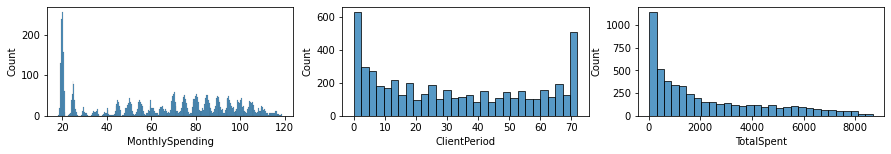

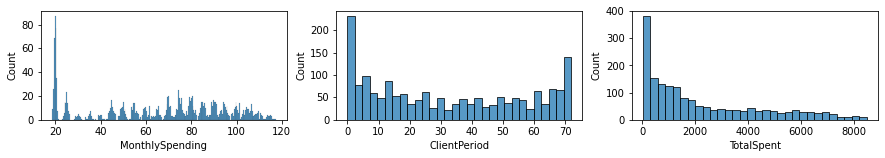

In [10]:
# MonthlySpending: multimodal normal distribution
# We can cut this feature accordingly into bins

def show_num_distributions(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    fig, axes = plt.subplots(1,3,figsize=(15,2))
    sns.histplot(data['MonthlySpending'], bins=250, ax=axes[0])
    sns.histplot(data['ClientPeriod'], bins=30, ax=axes[1])
    sns.histplot(data['TotalSpent'], bins=30, ax=axes[2]);

show_num_distributions(train_data.copy())
show_num_distributions(test_data.copy())

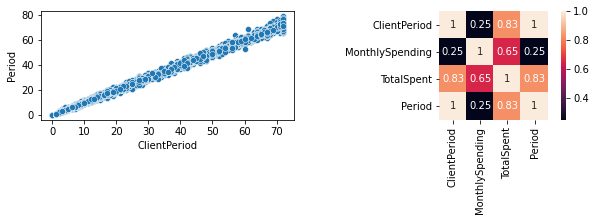

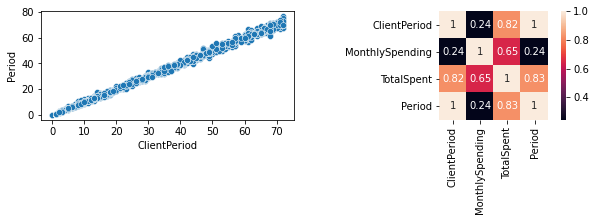

In [11]:
# Checking correlation between numerical variables
# ClientPeriod ~= TotalSpent / MonthlySpending
# Each of them can be linearly reconstructed from the others
# Maybe we shouldn't use one of these features

def show_correlation(data):
    num_cols_ = num_cols + ['Period']
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
    data['Period'] = data['TotalSpent'] / data['MonthlySpending']
    fig, axes = plt.subplots(1,2,figsize=(10,2))
    sns.scatterplot(x='ClientPeriod', y='Period', data=data, ax=axes[0])
    sns.heatmap(data[num_cols_].corr(method='pearson').abs(), annot=True, square=True, ax=axes[1]);

show_correlation(train_data.copy())
show_correlation(test_data.copy())

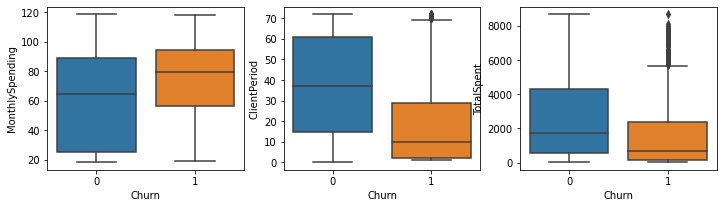

In [12]:
# Looking for outliers
# ClientPeriod: there are some (Churn = 1)
# TotalSpent: there are some (Churn = 1)
fig, axes = plt.subplots(1,3,figsize=(12,3))
train_data['TotalSpent'] = pd.to_numeric(train_data['TotalSpent'], errors='coerce')
sns.boxplot(x='Churn', y='MonthlySpending', data=train_data, ax=axes.flat[0])
sns.boxplot(x='Churn', y='ClientPeriod', data=train_data, ax=axes.flat[1])
sns.boxplot(x='Churn', y='TotalSpent', data=train_data, ax=axes.flat[2]);

,mean_diff,p_value
ClientPeriod,19.574321,1.509283e-155
TotalSpent,1038.002181,1.730280e-64
MonthlySpending,12.678458,4.243204e-37


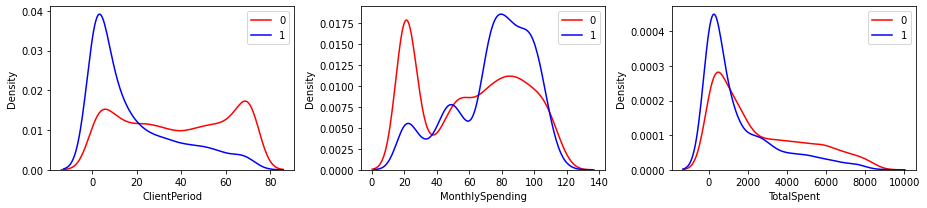

In [13]:
# Correlation between numeric features and categorical target
# Selecting numeric features based on difference in means of each class
# Mann-Whitney rank test for numeric features and categorical target variable
# Checking if our numeric features have signifficant difference in means (positive and negative class)
# All of our numeric features have significantly different means of each target class

def get_p_value(data, num_col, target_col):
    target = data[target_col]
    neg = data.loc[target == 0, num_col].dropna()
    pos = data.loc[target == 1, num_col].dropna()
    if len(neg) < 10 or len(pos) < 10: return 1
    return stats.mannwhitneyu(neg, pos)[1]

def show_significant_features(data, num_cols, target_col):
    target = data[target_col]
    means_neg = data.loc[target == 0, num_cols].mean()
    means_pos = data.loc[target == 1, num_cols].mean()
    mean_diff = np.abs(means_pos - means_neg)
    p_values = [get_p_value(data, col, target_col) for col in num_cols]
    df = pd.DataFrame({'mean_diff': mean_diff, 'p_value': p_values})
    display(df[df['p_value'] < 0.01].sort_values('p_value'))

def show_density_distribution(data, num_cols, target_col):
    target = data[target_col]
    fig, axes = plt.subplots(1, 3, figsize=(13, 3))
    for c, ax in zip(num_cols, axes.flat):
        sns.kdeplot(data.loc[target == 0, c], color='r', ax=ax, label=0)
        sns.kdeplot(data.loc[target == 1, c], color='b', ax=ax, label=1)
        ax.set_xlabel(c); ax.legend();
    fig.tight_layout()

data = train_data.copy()
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

show_significant_features(data, num_cols, target_col)
show_density_distribution(data, num_cols, target_col)

In [14]:
# Checking for outliers
# ClientPeriod: 18 outliers (Churn = 1, > 69.5)
# TotalSpent: 74 putliers (Churn = 1, > 5679.4)

def check_outliers(c):
    Q1 = c.quantile(0.25)
    Q3 = c.quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    print(f'Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}')
    print(f'low: {low:.2f}, high: {high:.2f}')
    print(f'outliers: {((c < low) | (c > high)).sum()}')

data = train_data.copy()
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
check_outliers(data[data['Churn'] == 1]['ClientPeriod'])
# check_outliers(data[data['Churn'] == 1]['TotalSpent'])

Q1: 2.00, Q3: 29.00, IQR: 27.00
low: -38.50, high: 69.50
outliers: 18


In [15]:
data[(data['ClientPeriod'] > 69.5) & (data['Churn'] == 1)].shape
# data[(data['TotalSpent'] > 5679.4) & (data['Churn'] == 1)].shape

(18, 20)

In [16]:
# Checking replacing outliers (including zeros)

def check_replacing_outliers(data, column, threshold):
    mask = (data[column] > threshold) & (data['Churn'] == 1)
    idx = data[mask].index
    data.loc[mask, column] = 0
    replace = lambda x: x.replace(0, x.median())
    data[column] = data.groupby('HasContractPhone')[column].apply(replace)
    display(data.loc[idx, ['HasContractPhone', column]])

data = train_data.copy()
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
check_replacing_outliers(data, 'ClientPeriod', 69.5)
# check_replacing_outliers(data, 'TotalSpent', 5679.4)

,HasContractPhone,ClientPeriod
506,One year,43.0
565,Two year,64.0
927,One year,43.0
1263,One year,43.0
1415,Two year,64.0
1756,Two year,64.0
1827,One year,43.0
1873,Two year,64.0
1933,Two year,64.0
2089,Two year,64.0


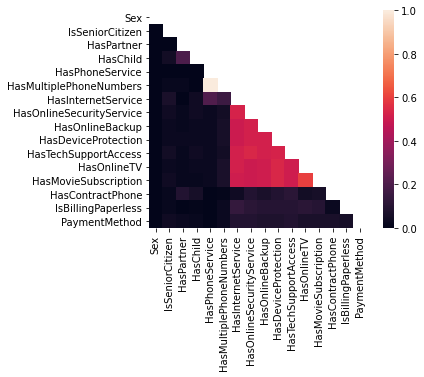

In [17]:
# Correlation between categorical features (Cramer's V)

def cramers_V(v1, v2):
    crosstab = np.array(pd.crosstab(v1, v2))
    stat = stats.chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape) - 1
    return (stat / (obs * mini))

def show_cat_correlation_matrix(data, cat_cols):
    label = LabelEncoder()
    data_encoded = pd.DataFrame()
    for c in cat_cols: 
        data_encoded[c] = label.fit_transform(data[c])
    rows = []
    for v1 in data_encoded:
        col = []
        for v2 in data_encoded:
            cramers =cramers_V(data_encoded[v1], data_encoded[v2])
            col.append(round(cramers, 2))
        rows.append(col)
    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns=data_encoded.columns, index=data_encoded.columns)
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df, mask=mask, vmin=0., vmax=1, square=True)

show_cat_correlation_matrix(train_data, cat_cols)

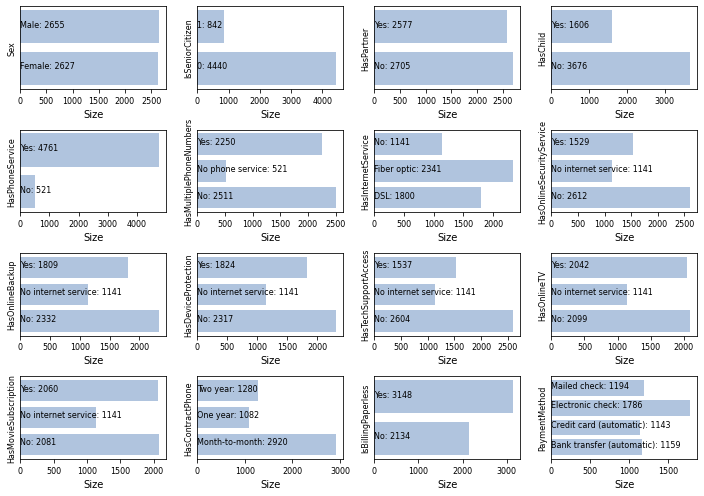

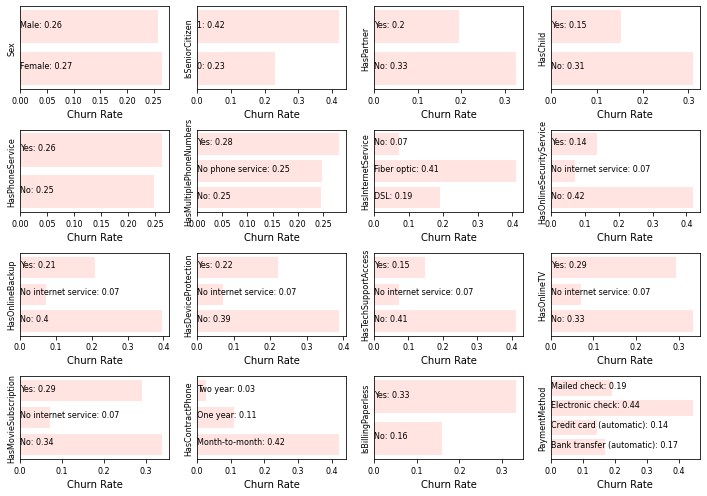

In [18]:
# Distribution of categorical features
# And their correlation with the target

def show_cat_report(data, cols, n_cols, target=None, figsize=(5,5)):
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for c, ax in zip(cols, axes.flat):
        g = data.groupby(c)
        cnt = g[target].mean() if target else g.size()
        color = 'mistyrose' if target else 'lightsteelblue'
        ax.barh(cnt.index.astype(str), cnt.values, color=color)
        ax.set_yticks([])
        ax.set_ylabel(c, fontsize=8)
        ax.set_xlabel(target + ' Rate' if target else 'Size')
        ax.tick_params(axis='x', labelsize=8)
        z = zip(range(len(cnt)), cnt.index, cnt.values)
        for i, k, v in z: ax.text(0, i, f'{k}: {round(v,2)}', fontsize=8)
    fig.tight_layout()

show_cat_report(train_data.copy(), cat_cols, n_cols=4, figsize=(10,7))
show_cat_report(train_data.copy(), cat_cols, n_cols=4, figsize=(10,7), target='Churn')

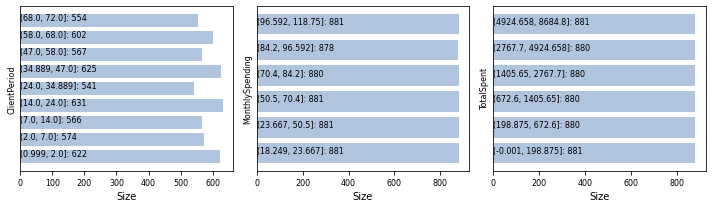

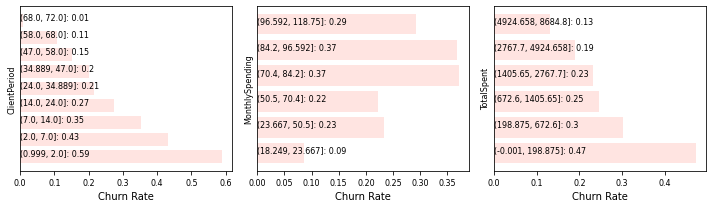

In [20]:
# Distribution of numeric variables (cut into bins)
# And their correlation with the target

data = train_data.copy()
replace = lambda x: x.replace(0, x.median())
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
data.loc[(data['ClientPeriod'] > 69.5) & (data['Churn'] == 1), 'ClientPeriod'] = 0
# data.loc[(data['TotalSpent'] > 5679.4) & (data['Churn'] == 1), 'TotalSpent'] = 0
data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace)
# data['TotalSpent'] = data.groupby('HasContractPhone')['TotalSpent'].apply(replace)
data['MonthlySpending'] = pd.qcut(data['MonthlySpending'], 6)
data['ClientPeriod'] = pd.qcut(data['ClientPeriod'], 9)
data['TotalSpent'] = pd.qcut(data['TotalSpent'], 6)

cols = ['ClientPeriod','MonthlySpending','TotalSpent']
show_cat_report(data, cols, n_cols=3, figsize=(10,3))
show_cat_report(data, cols, n_cols=3, figsize=(10,3), target='Churn')

In [39]:
# LogisticRegression (new)

def prepare_data(data, train=False):
    
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
    
    # if train: data.loc[(data['TotalSpent'] > 5679.4) & (data['Churn'] == 1), 'TotalSpent'] = 0
    # if train: data.loc[(data['ClientPeriod'] > 69.5) & (data['Churn'] == 1), 'ClientPeriod'] = 0
    # if train: data = data[((data['TotalSpent'] <= 5679.4) & (data['Churn'] == 1) | (data['Churn'] == 0))].copy()
    if train: data = data[((data['ClientPeriod'] <= 69.5) & (data['Churn'] == 1) | (data['Churn'] == 0))].copy()
    
    replace_zeros = lambda x: x.replace(0, x.median())
    # data['TotalSpent'] = data.groupby('HasContractPhone')['TotalSpent'].apply(replace_zeros)
    # data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace_zeros)
    # data['MonthlySpending'] = data.groupby('HasContractPhone')['MonthlySpending'].apply(replace_zeros)
    if train: data = data[data['ClientPeriod'] != 0].copy()
    else: data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace_zeros)
    
    # data['TotalSpentG'] = pd.qcut(data['TotalSpent'], 11).astype(str)
    # data['ClientPeriodG'] = pd.qcut(data['ClientPeriod'], 11).astype(str)
    # data['MonthlySpendingG'] = pd.qcut(data['MonthlySpending'], 11).astype(str)
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    # data['ClientPeriodG'] = pd.qcut(data['ClientPeriod'], 9).astype(str)
    # data['MonthlySpendingG'] = pd.qcut(data['MonthlySpending'], 6).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'), train=False)
train_data = prepare_data(pd.read_csv('./train.csv'), train=True)

# 'MonthlySpending','ClientPeriod','TotalSpent'
# 'ClientPeriodG','MonthlySpendingG','TotalSpentG'
num_cols_ = [] 
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG'] 

preprocessor = ColumnTransformer([
    ('0', OneHotEncoder(handle_unknown='ignore'), cat_cols_), 
    ('1', StandardScaler(), num_cols_),
    # ('2', PolynomialFeatures(2), num_cols_)
])

classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
shuffle = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=shuffle)
print(f'roc_auc: {s.mean():.4f} (mean), {s.std():.4f} (std)')
print(f'scores: {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

c = np.abs(model['clf'].coef_)
print(f'coef_: {c.min():.3f} (min), {c.max():.3f} (max), {(c==0).sum()} / {len(c[0])} (zeros)')

roc_auc: 0.8541 (mean), 0.0274 (std)
scores: [0.8458194  0.89122074 0.86538462 0.87249164 0.87382943 0.88136752
 0.86863248 0.81487179 0.78641026 0.86504274 0.79700855 0.87145299
 0.89470085 0.82589744 0.87760684 0.88717949 0.84666667 0.85649573
 0.86376068 0.86568925 0.86568925 0.87942366 0.85085945 0.82903606
 0.8355241  0.87032356 0.81648129 0.84807887 0.86012808 0.81479609]
coef_: 0.000 (min), 3.704 (max), 19 / 75 (zeros)


In [40]:
grid = {'clf__C':np.arange(0.1,1.4,0.1), 'clf__penalty':['l1']}
cv = GridSearchCV(model, grid, scoring='roc_auc', cv=StratifiedKFold(30))
cv.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
print(f"C: {params['clf__C']:.2f}, penalty: {params['clf__penalty']}")

C: 0.50, penalty: l1


In [75]:
# LogisticRegression (new 2)

def replace_zeros(x):
    return x.replace(0, x.median())

def get_target_rates(data, cat_cols, target_col):
    return {c: data.groupby(c)[target_col].mean().to_dict() for c in cat_cols}

def map_target_rates(data, cat_cols, target_rates):
    return data[cat_cols].apply(lambda x: x.map(target_rates[x.name]))

def clean_target_rates(target_rates):
    target_rates['HasMultiplePhoneNumbers']['No phone service'] = 0
    target_rates['HasOnlineSecurityService']['No Internet Service'] = 0
    target_rates['HasOnlineBackup']['No Internet Service'] = 0
    target_rates['HasDeviceProtection']['No Internet Service'] = 0
    target_rates['HasTechSupportAccess']['No Internet Service'] = 0
    target_rates['HasOnlineTV']['No Internet Service'] = 0
    target_rates['HasMovieSubscription']['No Internet Service'] = 0
    return target_rates

def prepare_data(data, train=False):
    
    if train: # dropping zeros and outliers
        data = data[data['ClientPeriod'] != 0].copy()
        data = data[((data['ClientPeriod'] <= 69.5) & (data['Churn'] == 1) | (data['Churn'] == 0))].copy()
    
    else: # test: replacing zeros with median
        data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace_zeros)
    
    # cutting numeric features into bins
    data['MonthlySpending'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    data['ClientPeriod'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    cat_cols_ = cat_cols + ['ClientPeriod','MonthlySpending']
    
    if train: # extracting target_rates from train dataset
        prepare_data.target_rates = get_target_rates(data, cat_cols_, target_col)
        # prepare_data.target_rates = clean_target_rates(prepare_data.target_rates)
    
    # mapping target rates (replacing categories with according rates)
    data[cat_cols_] = map_target_rates(data, cat_cols_, prepare_data.target_rates)
    return data

train_data = prepare_data(pd.read_csv('./train.csv'), train=True)
test_data = prepare_data(pd.read_csv('./test.csv'), train=False)

feature_cols = cat_cols + ['ClientPeriod','MonthlySpending']
model = LogisticRegression(C=1, penalty='l1', solver='liblinear')
shuffle = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
s = cross_val_score(model, train_data[feature_cols], train_data[target_col], scoring='roc_auc', cv=shuffle)
print(f'roc_auc: {s.mean():.4f} (mean), {s.std():.4f} (std)')
print(f'scores: {s}')

model.fit(train_data[feature_cols], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[feature_cols])[:,1]
submission.to_csv('./my_submission.csv', index=False)

c = np.abs(model.coef_)
print(f'coef_: {c.min():.3f} (min), {c.max():.3f} (max), {(c==0).sum()} / {len(c[0])} (zeros)')

roc_auc: 0.8526 (mean), 0.0270 (std)
scores: [0.83871237 0.89071906 0.86362876 0.86262542 0.86881271 0.87410256
 0.87051282 0.82709402 0.78504274 0.86495726 0.79615385 0.86982906
 0.88632479 0.81846154 0.87145299 0.89358974 0.84905983 0.84393162
 0.88547009 0.86653185 0.87091338 0.87639029 0.84352882 0.8293731
 0.8376306  0.86653185 0.81917762 0.84521402 0.84192787 0.81884058]
coef_: 0.000 (min), 4.355 (max), 5 / 18 (zeros)


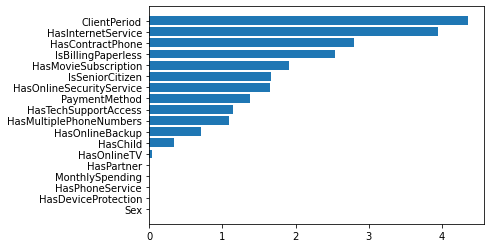

In [76]:
def show_feature_weights(coef, cols):
    indices = np.argsort(np.abs(coef))
    cols = [cols[i] for i in indices]
    plt.barh(cols, np.abs(coef)[indices])

show_feature_weights(model.coef_[0], feature_cols)

In [34]:
grid = {'C':np.arange(1,2,1), 'penalty':['l1']}
cv = GridSearchCV(model, grid, scoring='roc_auc', cv=StratifiedKFold(30))
cv.fit(train_data[feature_cols], train_data[target_col])
params = cv.best_estimator_.get_params()
print(f"C: {params['C']:.2f}, penalty: {params['penalty']}")
c = np.abs(cv.best_estimator_.coef_)
print(f'coef_: {c.min():.3f} (min), {c.max():.3f} (max), {(c==0).sum()} / {len(c[0])} (zeros)')

C: 1.00, penalty: l1
coef_: 0.000 (min), 4.357 (max), 5 / 18 (zeros)


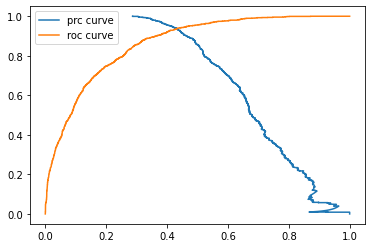

In [130]:
y = train_data[target_col]
p = model.predict(train_data[cat_cols_ + num_cols_])
scores = model.predict_proba(train_data[cat_cols_ + num_cols_])[:,1]
precision, recall, thresholds = precision_recall_curve(y, scores)
fpr, tpr, thresholds = roc_curve(y, scores)
plt.plot(precision, recall, label='prc curve')
plt.plot(fpr, tpr, label='roc curve')
plt.legend();

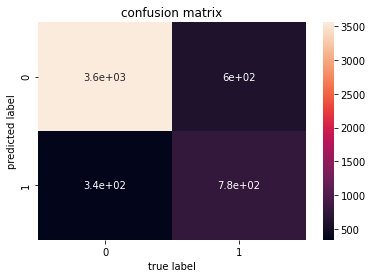

In [496]:
mat = confusion_matrix(y, p)
sns.heatmap(mat.T, annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('confusion matrix');

In [122]:
# LogisticRegression (kaggle 0.85361)

def prepare_data(data, train=False):
    
    if train: data = data[((data['ClientPeriod'] <= 69.5) & (data['Churn'] == 1) | (data['Churn'] == 0))].copy()
    
    replace_zeros = lambda x: x.replace(0, x.median())
    data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace_zeros)
    data['MonthlySpending'] = data.groupby('HasContractPhone')['MonthlySpending'].apply(replace_zeros)
    
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'), train=False)
train_data = prepare_data(pd.read_csv('./train.csv'), train=True)

num_cols_ = []
cat_cols_ = cat_cols + ['MonthlySpendingG','ClientPeriodG']
num_tran, cat_tran = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([('cat', cat_tran, cat_cols_), ('num', num_tran, num_cols_)])
classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
shuffle = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=shuffle)
print(f'roc_auc: {s.mean():.4f} (mean), {s.std():.4f} (std)')
print(f'scores: {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

c = np.abs(model['clf'].coef_)
print(f'coef_: {c.min():.3f} (min), {c.max():.3f} (max), {(c==0).sum()} / {len(c[0])} (zeros)')

roc_auc: 0.8550 (mean), 0.0317 (std)
scores: [0.8319398  0.91095318 0.88913043 0.87617057 0.82198997 0.87048495
 0.87257525 0.86103679 0.77274247 0.86404682 0.81505017 0.89498328
 0.84397993 0.88444816 0.88888889 0.89982906 0.8425641  0.89136752
 0.8757265  0.85478632 0.87521368 0.86717949 0.85863248 0.81410256
 0.81820513 0.81760684 0.83547009 0.81863248 0.83358611 0.84984833]
coef_: 0.000 (min), 3.701 (max), 18 / 75 (zeros)


In [126]:
# LogisticRegression (kaggle 0.85303)

def prepare_data(data):
    data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(lambda x: x.replace(0, x.median()))
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = []
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG']
num_tran, cat_tran = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([('cat', cat_tran, cat_cols_), ('num', num_tran, num_cols_)])
classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
shuffle = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=shuffle)
print(f'roc_auc: {s.mean():.4f} (mean), {s.std():.4f} (std)')
print(f'scores: {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

c = np.abs(model['clf'].coef_)
print(f'coef_: {c.min():.3f} (min), {c.max():.3f} (max), {(c==0).sum()} / {len(c[0])} (zeros)')

roc_auc: 0.8492 (mean), 0.0342 (std)
scores: [0.76325696 0.87307692 0.84573579 0.8493311  0.82792642 0.87826087
 0.87901338 0.91379599 0.80501672 0.91137124 0.84899666 0.88494983
 0.82466555 0.83444816 0.86923077 0.84297659 0.86471572 0.85702341
 0.87474916 0.87165552 0.86070234 0.87006689 0.86688963 0.815301
 0.86755853 0.78779264 0.82324415 0.81956522 0.85304305 0.79209962]
coef_: 0.000 (min), 1.709 (max), 22 / 75 (zeros)


In [127]:
# CatBoostClassifier (kaggle 0.85283)

def prepare_data(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    data['TotalSpent'] = data['TotalSpent'].fillna(0)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = num_cols
cat_cols_ = cat_cols
catboost = CatBoostClassifier(learning_rate=0.16, num_trees=63)
catboost.set_params(cat_features=cat_cols_, silent=True)
s = cross_val_score(catboost, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=10)
print(f'roc_auc: {s.mean():.4f} (mean), {s.std():.4f} (std)')
print(f'scores: {s}')

catboost.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = catboost.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

roc_auc: 0.8480 (mean), 0.0110 (std)
scores: [0.85309906 0.86536617 0.85293571 0.83297101 0.85815682 0.82840951
 0.84746377 0.85682832 0.84400141 0.84039504]


In [ ]:
grid = {'learning_rate':[0.155,0.16,0.165], 'num_trees':[60,61,62,63,64]}
catboost = CatBoostClassifier().set_params(cat_features=cat_cols, silent=True)
cv = GridSearchCV(catboost, grid, scoring='roc_auc', cv=10)
cv.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
params['learning_rate'], params['num_trees']